#### Import necessary dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import json
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Part 1 ‐ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.


#### Read in data

In [2]:
login_df = pd.read_json("logins.json")

In [3]:
print(login_df.shape)
login_df.head()

(93142, 1)


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
print(login_df.isna().sum())

login_time    0
dtype: int64


In [5]:
#Aggregate login counts into 15 minute intervals
grouped_login_df = login_df.set_index('login_time')
grouped_login_df['count'] = 1
grouped_login_df = grouped_login_df.resample('15T').sum()

In [6]:
grouped_login_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


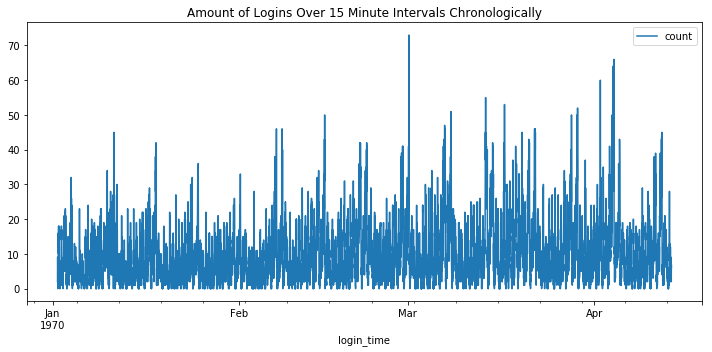

In [7]:
grouped_login_df.plot(figsize = (10,5), title = "Amount of Logins Over 15 Minute Intervals Chronologically")
plt.tight_layout()

The data looks very catapilleraly, as they say in data lingo. It looks to me like the amount of logins spikes on the weekends, and falls back down during the weekdays. This is because per month, there are about four spikes and four valleys. The valleys are consistently wider and mountains thinner, consistent with weekday versus weekend.

### Time of day categories

Overnight: 12am - 6am

Morning: 6am - 12pm

Afternoon: 12pm - 6pm

Evening: 6pm - 12am

In [8]:
def categorize_TOD(time):
    if time.hour < 6:
        return "Overnight"
    elif time.hour < 12:
        return "Morning"
    elif time.hour < 18:
        return "Afternoon"
    else:
        return "Evening"

In [9]:
login_df["TOD_category"] = login_df.login_time.apply(categorize_TOD)

In [10]:
login_df.head()

,login_time,TOD_category
0,1970-01-01 20:13:18,Evening
1,1970-01-01 20:16:10,Evening
2,1970-01-01 20:16:37,Evening
3,1970-01-01 20:16:36,Evening
4,1970-01-01 20:26:21,Evening


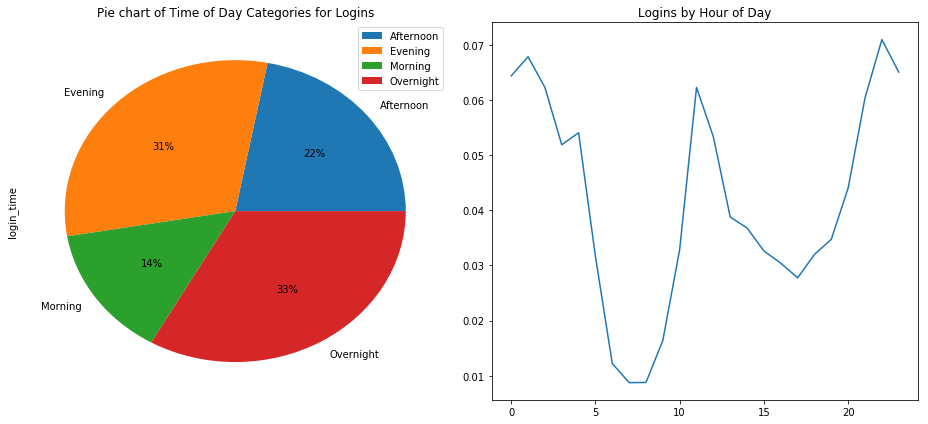

In [11]:
f, ax = plt.subplots(1,2, figsize = (13, 6))

ax1 = plt.subplot(121)
login_df.groupby("TOD_category").count().plot(kind = "pie", y = "login_time", autopct='%1.0f%%', 
                                            title ="Pie chart of Time of Day Categories for Logins", ax = ax1)
ax2 = plt.subplot(122)
dates = pd.to_datetime(login_df.login_time.values)
plt.plot(dates.hour.value_counts(sort = False, normalize = True))
ax2.set_title("Logins by Hour of Day")
plt.tight_layout()

Examining the pie chart first, looks like activity steadily increases from morning, to afternoon, to evening, to overnight. The two biggest aggregate chunk time intervals are evening and overnight, which account for about 64% of all logins. This indicates most people use the driving services while its dark out.

Moving on to the line graph, this is a bit more descriptive. Here we can see that activity peaks around midnight, and then rapidly drops till it reaches a global minimum between 7-8am. This may be because most people are going to or getting ready for work around this time, and already have a means of transportation figured out, because if they didn't it would be expensive to have to use a driving services ~5 days out of the week just to go to work, and perhaps even come back. After this we see our first rapid incease, reaching a local maximum at around 12pm, perhaps indicating that people are going to lunch and need a ride to where ever that may be. A steady, less rapid decrease follows this reaching a local minimum around 6pm. This is consistent with what we inferred earlier in that most people may be leaving work around this time and already have a means of transportation figured out. After this, we begin a final ascent to our global maximum at around midnight, which suggests people need a driver partner because they themselves cannot drive.

# Part 2 - Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

b. what statistical test(s) you will conduct to verify the significance of the
observation

c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

First off, the key factor to notice here is that we're specifically concerned with meas

1. I believe looking at the total time spent each population spends in the neighboring city coupled with the median time spent among citizens of each city would be an effective metric to look at. From here we would separate these two categories for each city into information for weekend and weekday. The total will give us a high level idea of the population migration, but wont give us a good idea of whats going on at the individual level. Consider a scenario where Gotham has a population of 100, and 99 of them stay in Gotham and never travel to Metropolis, while the 1 left out goes and essentially moves to Metropolis. With a high level metric like this, we won't be able to understand whats going on and see that on an individual level eliminating the toll has not been an effective metric for the vast majority of the population. All we will be able to see is the aggregate and perhaps incorrectly infer that everyone is spending some time in the adjacent city of Metropolis. This is where considering the median comes in. If our data has outliers, then examining the median amount of time spent in the adjacent city should account for this and give us a better idea of whats going on at an individual level. If we wanted to get even more descriptive, we could look at these metrics and break it up into subcategories, analyzing each cities during their respective peak activity time. It's reasonable to assume that while one city is in its downtime, most citizens will be in their home which is located in their own city so they wont be traveling. Thus more explicity it might look something like total time Metropolis citizens spend in Gotham during the day coupled with median time among citizens, and total time Gotham citizens spend in Metroplois during the night coupled with median time among citizens. 

2. I think the most pratical experiment you could implement would be to transform the toll road sensors into sensors to track activity between cities. Having violated toll roads before (oops), unfortunately I know for a fact that they have technology that takes pictures of your license plate and from there is able to track down your home address to send you mail. This technology could instead be used as a log keeping track of each vehicles time spent in each city. This should then make things reasonably straight forward to separate Gotham vehicles from Metropolis ones, and group license plates with its corresponding house and citizens to calculate the median. 



# Part 3 ‐ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).



In [12]:
#Read in data. data is malformed and pd.read_json does not operate as expected, so I created a manual function to read 
#in and write the data to a pandas dataframe
def load_file(file_path):
    d = {}
    with open(file_path, "r") as file:
        for line in file:
            lst = json.loads(line)
            for row in lst:
                for k, v in row.items():
                    if k in d.keys():
                        d[k].append(v)
                    else:
                        d[k] = [v]
    return pd.DataFrame(d)
ultimate_df = load_file("ultimate_data_challenge.json")

### Data Description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [13]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
print(ultimate_df.shape)
ultimate_df.isna().sum()

(50000, 12)


city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [15]:
ultimate_df.dropna(inplace=True)
#Convert columns to datetime so that we can perform arithmetic with the dates to get differences
ultimate_df.last_trip_date = pd.to_datetime(ultimate_df.last_trip_date)
ultimate_df.signup_date = pd.to_datetime(ultimate_df.signup_date)

#### Engineer the target feature for 2. Recall
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

There are a couple things to consider here that our dataframe conveniently takes care of. The signups are all contained within the month of january, and the most recent last day active in the dataframe is exactly the beginning of the seventh month of the year. This means that the last_trip_date will perfectly indicate whether or not a user was active during their 6 month if their last date is within the past 31 days. We engineered this feature above.
The company defines a user as active if theyve had a trip in the first 30 days. First we'll calculate the number of days since the users last trip, and then we can create binary labels as to whether or not the user is active.

In [16]:
#convert dates to datetime so we can perform arithmetic on them
ultimate_df.last_trip_date = pd.to_datetime(ultimate_df.last_trip_date)

#get most recent logged date in our data
most_recent = ultimate_df.last_trip_date.max()

#calculate how many days its been since user was last active
ultimate_df["days_since_active"] = ultimate_df.last_trip_date.apply(lambda date: (most_recent - date).days)

#calculate whether or not a user is active as defined above
ultimate_df["active"] = ultimate_df["days_since_active"].apply(lambda days: 1 if days <= 31 else 0)

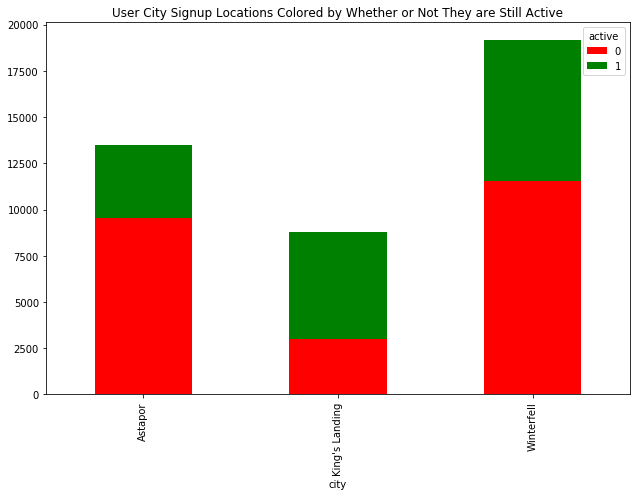

In [17]:
ultimate_df.groupby(['city', 'active']).size().unstack().plot(kind='bar', stacked=True, color = ["r", "g"],
                                figsize = (9,7),
                                title ="User City Signup Locations Colored by Whether or Not They are Still Active")

plt.tight_layout()

Looks like proportionally, there is a lot of active people in King's Landing (over half), however it has the smallest population. Winterfell comes in second with a little more than 1/3rd of users being active and having the largest population. 

In [18]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_since_active,active
count,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000,41445.000000
mean,2.609675,4.601720,1.073822,8.898709,61.254897,5.460046,4.776446,67.423405,0.419640
std,4.059336,0.616104,0.198747,18.322061,34.813848,5.145174,0.404606,60.798925,0.493506
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000,11.000000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.780000,5.000000,46.000000,0.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000,127.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000,181.000000,1.000000


It makes sense that the average rating of a driver is high, as having use these systems before as long as the dude youre driving with isn't a total weirdo or potential serial killer, you're probably going to give them 4 or 5 stars. 

Average surge is only 1.07, which suggests most users aren't taking trips during the surge period. The small standard deviation coupled with this seems to reinforce this hypothesis. 

Weekday percentage is 61%, with a high standard deviation of 34%. We'll be able to understand this better in our histograms when we look at the distributions. 

Average distance is about 5 miles, with a standard deviation of 5 as well, which suggests the vast majority of users are taking trips between 0-10 miles. 

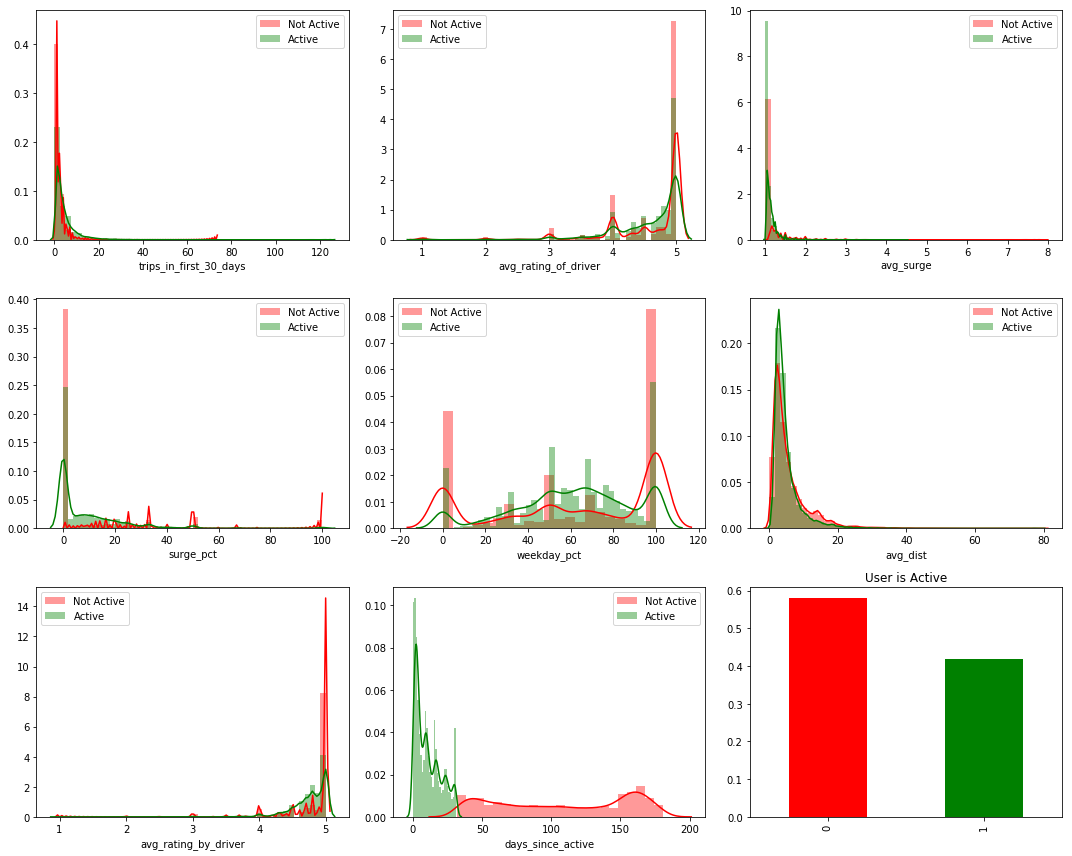

In [19]:
columns = ["trips_in_first_30_days","avg_rating_of_driver","avg_surge","surge_pct",
           "weekday_pct","avg_dist","avg_rating_by_driver", "days_since_active"]
f, ax = plt.subplots(3,3, figsize=(15,12))

for i, col in enumerate(columns):
    i += 1
    plt.subplot(3,3,i)
    sns.distplot(ultimate_df[col][ultimate_df["active"] == 0], color='r', label = 'Not Active')
    sns.distplot(ultimate_df[col][ultimate_df["active"] == 1], color = "g", label = "Active")
    plt.legend(loc='best')
plt.subplot(339)
ultimate_df.active.value_counts(normalize = True).plot.bar(title = "User is Active", color = ["r", "g"])

plt.tight_layout()

Despite there being more inactive users compared to active, the active users are much more evenly distributed among the weekday percentage usage. It seems like theres an even spread with a slight increase from 0 to 100% for active userrs, while as inactive users are much more skewed towards either 0% activity on the weekdays to 100% on the weekdays. This may be because there are a lot of users who are inactive that only used the app once or twice, and then never again, thus not having enough samples to even out they weekday_pct usage.

The surge_pct suggests that most active users stick between 0-20% of trips taken when the surge is in play, while there is a lot more variability with inactive users.

We can get a closer look at the features with heavily overlapping data by looking at the means in the next plot.

#### Mean of Features Separated by Active Label

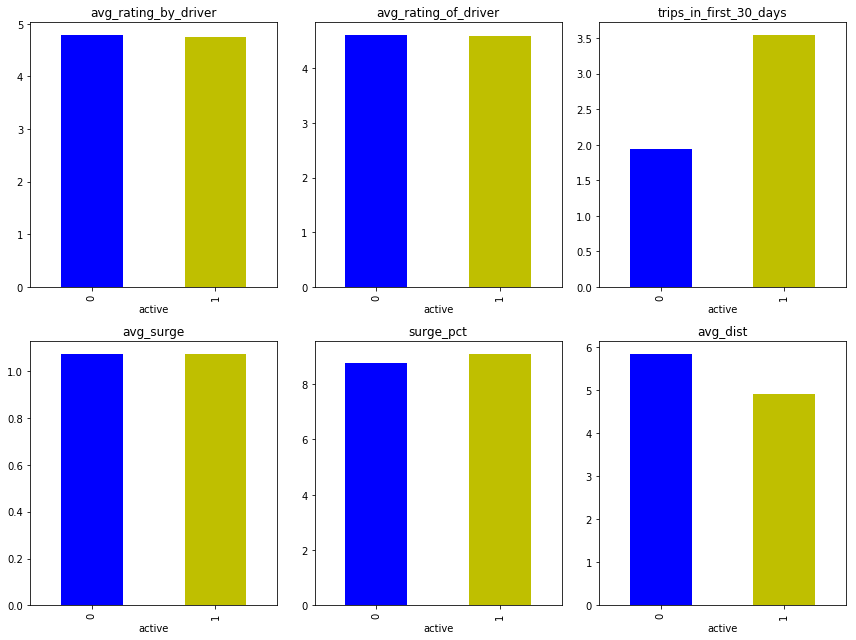

In [20]:
columns = ["avg_rating_by_driver", "avg_rating_of_driver", "trips_in_first_30_days",
           "avg_surge", "surge_pct", "avg_dist"]
f,ax = plt.subplots(2,3, figsize = (12,9))
for i, col in enumerate(columns):
    i+=1
    plt.subplot(2,3,i)
    ultimate_df.groupby(["active"])[col].mean().plot(kind = "bar", colors = ["b", "y"], title = col)
plt.tight_layout()

The only real thing to note here is that active users end up taking about two more trips on average in their first 30 days when compared with inactive users.

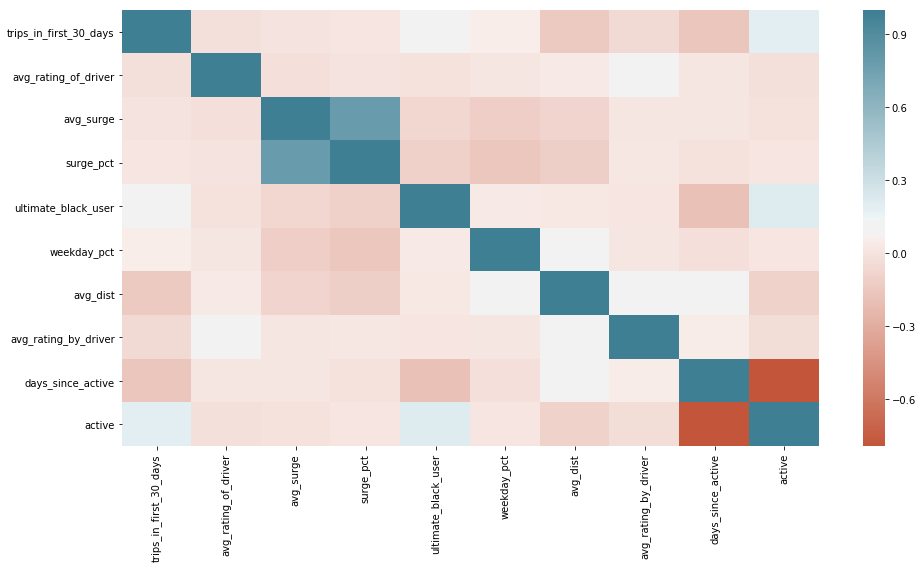

In [21]:
f, ax = plt.subplots(figsize = (14,8))
corr = ultimate_df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap = sns.diverging_palette(20, 220, n=256))
plt.tight_layout()

Looks like for active, the highest correlations are between whether or not the user is an ultimate black user and how many trips the user took in the first thirty days. 

There is a small negative correlation between the average distance and activity, implying that users that have a longer average distance are less likely to be active. This may be because if the user has a large distance to travel, then using driver services may be very expensive and the user opts for another cheaper alternative.

There appears to be a positive correlation between days since a user was active and how many trips they took in their first 30 days. It's reassuring to see this, as it's natural to infer that those who use the service more in the first 30 days are more likely to continue using it throughout our time period. Additionally it looks like users who stick with the service use the ultimate black service in their first 30 days.

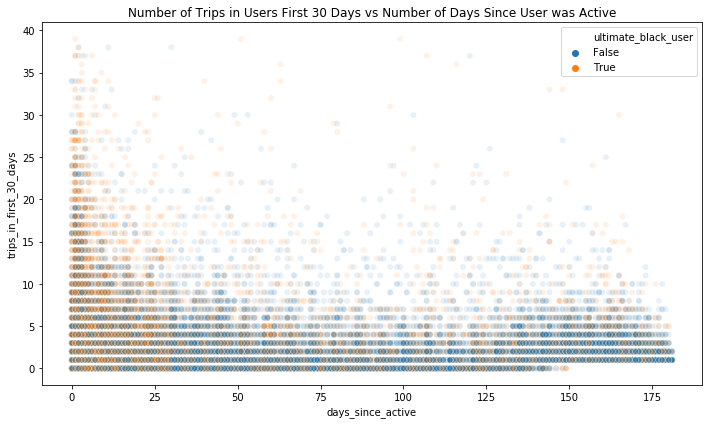

In [22]:
f, ax = plt.subplots(figsize = (10,6))

sub = ultimate_df[ultimate_df.trips_in_first_30_days < 40]
sns.scatterplot(y= "trips_in_first_30_days", x = "days_since_active", data = sub, 
                hue = "ultimate_black_user", alpha = .1)
ax.set_title("Number of Trips in Users First 30 Days vs Number of Days Since User was Active")
plt.tight_layout()

The ultimate black users are much more densely populated in the bottom left quartile of our graph, Which means that a lot them have been active recently and have a slightly higher number of trips in the first 30 days. Whatever the ultimate black service is, it seems to be very effective in retaining users, along with there being a slight positive correlation with number of trips a user takes in their first 30 days and how recently theyve been active, as we noted in the previous correlation matrix.

### Predictive Modeling

For our modeling we'll choose three different methods of which I have found to be most effective: Logistic Regression, Random Forest, and Xgboost.

In [23]:
ultimate_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
days_since_active                  int64
active                             int64
dtype: object

In [24]:
ultimate_df.city = ultimate_df.city.astype(str)

In [25]:
ultimate_df.city.value_counts()

Winterfell        19161
Astapor           13509
King's Landing     8775
Name: city, dtype: int64

There are only three different kinds of cities and this data may be useful for predictive modeling. However, since it they are strings, we won't be able to use this feature in its current state. Since there are only 3 categories, we can use one hot encoding.

In [26]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(ultimate_df.city)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

enc = OneHotEncoder(handle_unknown='ignore', sparse = False)
encodings = enc.fit_transform(integer_encoded)
encodings[:5]

array([[ 0.,  1.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.]])

In [27]:
ultimate_df.city.head()
#Astapor - First Column
#Kings Landing - Second Column
#Winterfell - Third Column

0    King's Landing
1           Astapor
2           Astapor
3    King's Landing
4        Winterfell
Name: city, dtype: object

In [28]:
encoding_df = pd.DataFrame(encodings, columns = ["Astapor", "King's Landing", "Winterfell"])

#Change ultimate_black_user from True-False to 1-0
ultimate_df.ultimate_black_user = ultimate_df.ultimate_black_user * 1

numeric_df = ultimate_df._get_numeric_data()

numeric_df.reset_index(inplace=True)
encoding_df.reset_index(inplace=True)
final_df = pd.concat([numeric_df, encoding_df], axis = 1)
final_df.drop(columns = ["index"], inplace = True)

X,y = final_df.drop(columns = ["active", "days_since_active"]), final_df.active
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Astapor,King's Landing,Winterfell
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0.0,1.0,0.0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,1.0,0.0,0.0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1.0,0.0,0.0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,0.0,1.0,0.0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,0.0,0.0,1.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 13)

#### Logistic Regression

In [30]:
#Baseline Logistic Regression Model 
penalty = ['l1', 'l2']
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
solver = ['liblinear', 'saga']

param_grid = dict(penalty=penalty,
                  C=C,
                  class_weight=class_weight,
                  solver=solver)

grid = GridSearchCV(estimator=LogisticRegression(random_state = 13),
                    param_grid=param_grid,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

opt_LR = grid.best_estimator_
lr_scores = [grid_result.best_score_, opt_LR.score(X_test, y_test)]

In [31]:
#Random Forest Model
n_estimators = [10,50,100]
max_features = ['auto', 'sqrt']
max_depth = [5,10,15, None]
min_samples_split = [10]
min_samples_leaf = [4]
bootstrap = [True, False]
param_grid = {'n_estimators': n_estimators, 'min_samples_leaf': min_samples_leaf, 
              'min_samples_split': min_samples_split, 'bootstrap': bootstrap, 'max_features': max_features, 
              'max_depth': max_depth}

grid = GridSearchCV(estimator=RandomForestClassifier(random_state = 13),
                    param_grid=param_grid,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

opt_RF = grid.best_estimator_
rf_scores = [grid_result.best_score_, opt_RF.score(X_test, y_test)]

In [32]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
grid = GridSearchCV(estimator=XGBClassifier(random_state = 13),
                    param_grid=param_grid,
                    n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

opt_XGB = grid.best_estimator_
xgb_scores = [grid_result.best_score_, opt_XGB.score(X_test, y_test)]

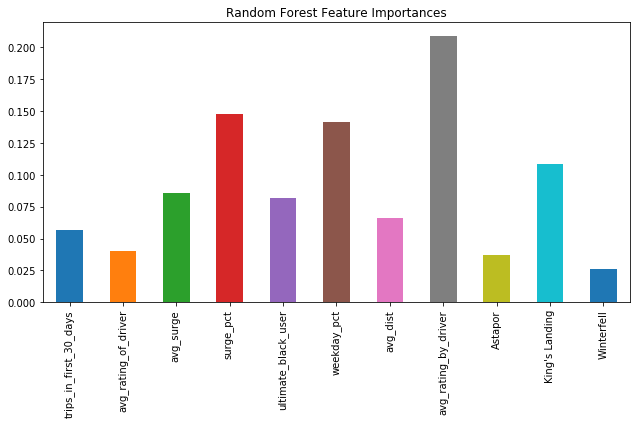

In [33]:
feature_significances = pd.Series(opt_RF.feature_importances_, index = X_train.columns)
feature_significances.plot(kind = "bar", figsize = (9,6))
plt.title("Random Forest Feature Importances")
plt.tight_layout()

Surprisingly enough, it looks like the most useful feature for the random forest model was avg rating by driver. One might infer from this that a lower rating by the driver correspond with an inactive driver, and vice versa where people who use the service often are most likely more pleasantly rated by the driver.

Surge pct and weekday pct are the other two features that stick out which we dove into earlier. From this a possible deduction that coincides with our earlier findings is that those who use the app more frequently don't get hit with the surge, and normally take rides on the weekends. Whereas people who hit the surge percentage a lot probably drive on the weekends and thus have a lower weekday percentage, perhaps rendering them inactive because they find the service expensive based on their usage.

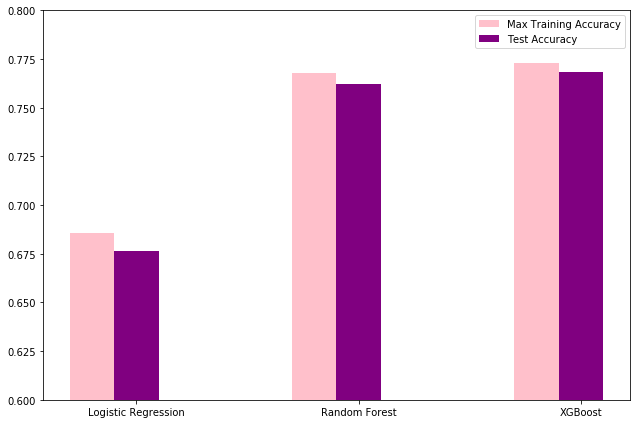

In [34]:
classifiers = ["Logistic Regression", "Random Forest", "XGBoost"]
stats2 = [lr_scores,rf_scores,xgb_scores]
ind = np.arange(3)
fig, ax = plt.subplots(figsize = [9,6])
width = .2
p1 = ax.bar(ind, [i[0] for i in stats2] , width, color='pink')
p2 = ax.bar(ind + width, [i[1] for i in stats2], width, color='purple')
ax.set_xticks(ind+width)
ax.set_xticklabels(["Logistic Regression", "Random Forest", "XGBoost"])
ax.legend((p1[0], p2[0]), ("Max Training Accuracy", "Test Accuracy"))
ax.set_ylim((.6,.8))
plt.tight_layout()

Decent results from Random Forest and XGBoost, with a test accuracy nearing 80%. They both perform similarly and outperform logistic regression significantly.

### Insights

First off, whatever the ultimate black feature is, it seems like Ultimate should encourage new users to try this as there is a strong correlation between people being active recently and them using that feature in their first 30 days.

It appears that the most consistent users are those that use the service on the weekdays, so building enterprise there may be best for long term sustainability. 

Based off of the model we saw that average rating by the driver was an important feature, which suggests that Ultimate should encourage users who have high rating by drivers to stay active, perhaps some sort of incentive in the form of a discount for users who get x amount of 5 star ratings by the driver. 

We also saw that users who are active took about 2 more trips on average in their first month, 1.8 to 3.5, so encourage users to take atleast 3 trips in their first month by again some sort of incentive where they get a discount for their first 3 rides or something like that. That would appear to help the customer retention rate.